# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score,hamming_loss

from sklearn.multiclass import OneVsRestClassifier

# Extrapolatory Data Analysis

1. We find the number of rows,columns in the dataset
2. We find the classwise distribution of the text
3. Find the average word count in the dataset to know whether the text classification is to be done on short or long sentences

## Observations

1. We have very less samples per class for some classes
2. Number of rows is 915
3. Text size is small i.e average word count is 4-5 words per sentence


In [2]:
data = pd.read_excel("data_set.xlsx")
data.head()

,intent,message
0,abs,Its a switchable abs
1,abs,kya ye switchable abs hai
2,abs,How many chanenls in th ABS
3,abs,abs mai kitne channels hai
4,abs,Is ABS there


In [3]:
# for use in classwise classification report
labels_list = list()
for i in range(data.shape[0]):
    if data.iloc[i,0] not in labels_list:
        labels_list.append(data.iloc[i,0])
# print(labels_list)

In [4]:
print("Number of rows-->",data.shape[0])
print("Number of columns-->",data.shape[1])

Number of rows--> 915
Number of columns--> 2


In [5]:
data['intent'].value_counts()

newDesign                     35
ducati                        32
safetyMeasuresCovid           26
complaints                    26
Apparel                       26
instrumentCluster             24
launchSignup                  23
tbtNavigation                 23
ducatiFinance                 22
fuelCapacity                  22
tubelessTyres                 22
ducatiAvailabilityDelivery    22
bookTestRide                  22
bookingAmount                 21
serviceCost                   21
locateDealer                  20
comfort                       20
braking                       19
ducatiColours                 18
miy                           18
downloadWallpapers            18
rsa                           18
faceFilters                   18
power                         17
bs6                           17
engine                        16
ducatiPrice                   16
usbPort                       16
mileage                       15
seatHeight                    15
ducatiApp 

<AxesSubplot:>

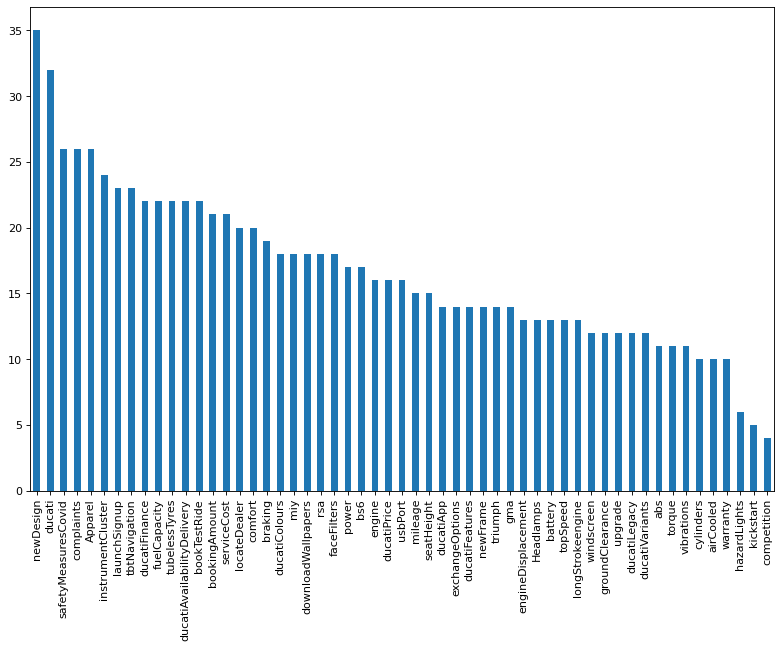

In [6]:
figure(figsize=(12, 8), dpi=80)
data['intent'].value_counts().plot(kind='bar')

In [7]:
sentence_list = data['message'].tolist()
word_count = 0
for sentence in sentence_list:
    word_count+=len(sentence.split(" "))
average_word_count = word_count/data.shape[0]
print("Average word count-- ",average_word_count)

Average word count--  4.787978142076502


# Data Preprocessing

1. It includes cleaning the text i.e removing non alphabetic characters and converting the text to lower case etc.

### Note ###
1. Not removing stopwords here as the text size is already small and removing it degrades model performance

In [8]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

data['message'] = data['message'].apply(lambda x:clean_text(x))


# Data preparation

1. It involves encoding the data class label into multiclass label form
2. Creating the TF IDF vectorizer

In [9]:
for i in range(data.shape[0]):
    data.iloc[i,0] = [data.iloc[i,0]]
    
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(data['intent'])

In [10]:
multilabel.classes_

array(['Apparel', 'Headlamps', 'abs', 'airCooled', 'battery',
       'bookTestRide', 'bookingAmount', 'braking', 'bs6', 'comfort',
       'competition', 'complaints', 'cylinders', 'downloadWallpapers',
       'ducati', 'ducatiApp', 'ducatiAvailabilityDelivery',
       'ducatiColours', 'ducatiFeatures', 'ducatiFinance', 'ducatiLegacy',
       'ducatiPrice', 'ducatiVariants', 'engine', 'engineDisplacement',
       'exchangeOptions', 'faceFilters', 'fuelCapacity', 'gma',
       'groundClearance', 'hazardLights', 'instrumentCluster',
       'kickstart', 'launchSignup', 'locateDealer', 'longStrokeengine',
       'mileage', 'miy', 'newDesign', 'newFrame', 'power', 'rsa',
       'safetyMeasuresCovid', 'seatHeight', 'serviceCost',
       'tbtNavigation', 'topSpeed', 'torque', 'triumph', 'tubelessTyres',
       'upgrade', 'usbPort', 'vibrations', 'warranty', 'windscreen'],
      dtype=object)

In [11]:
# using tfidf vectorizer for feature extraction as no embedding can be used 
# also with small data samples no good embedding can be created
tfidf = TfidfVectorizer(analyzer='word', max_features=1500, ngram_range=(1,3), stop_words='english')
X = tfidf.fit_transform(data['message'])
print(X.shape, y.shape)

(915, 1500) (915, 55)


# Model Training

1. We first split the dataset in 60:40 ratio as asked in document
2. We use three classifiers
        * SGD Classifier
        * SVM with Linear kernel
        * Decision Tree 
3. Do the model training on 60% of the samples and testing on 40% of samples and generate metrics report

In [12]:
#splitting into 60:40 ratio as per assignment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [13]:
sgd = SGDClassifier()
svc = LinearSVC()
decision_tree = DecisionTreeClassifier()

In [14]:
from sklearn.metrics import accuracy_score,hamming_loss,precision_score,recall_score,f1_score
def print_metrics_report(clf,y_test,y_pred):
    print("Clf: ", clf.__class__.__name__)
    print('Exact Match Ratio: {0}'.format(np.round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100,2)))

    print('Hamming loss: {0}'.format(np.round(hamming_loss(y_test, y_pred)*100,2))) 
    print('Recall: {0}'.format(np.round(precision_score(y_test, y_pred, average='micro')*100,2)))
    print('Precision: {0}'.format(np.round(recall_score(y_test,y_pred, average='micro')*100,2)))
    print('F1 Measure: {0}'.format(np.round(f1_score(y_test, y_pred, average='micro')*100,2))) 
    print('-------------')
    print("")

In [28]:
for classifier in [svc,sgd,decision_tree]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_metrics_report(classifier,y_test,y_pred)

Clf:  LinearSVC
Exact Match Ratio: 46.72
Hamming loss: 1.05
Recall: 90.16
Precision: 47.54
F1 Measure: 62.25
-------------

Clf:  SGDClassifier
Exact Match Ratio: 60.93
Hamming loss: 0.85
Recall: 84.45
Precision: 65.3
F1 Measure: 73.65
-------------

Clf:  DecisionTreeClassifier
Exact Match Ratio: 60.66
Hamming loss: 0.87
Recall: 81.52
Precision: 67.49
F1 Measure: 73.84
-------------



# Hyperparameter Tuning

In [16]:
# Hyper parameters range intialization for tuning 

parameters={
    "estimator__splitter":["best","random"],
            "estimator__max_depth" : [1,9,17,24],
           "estimator__min_samples_leaf":[1,3,5],
#            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "estimator__max_features":["auto","sqrt",None],
           "estimator__max_leaf_nodes":[None,10,20,30,40,50,70] 
           }

In [17]:
clf = OneVsRestClassifier(decision_tree)
clf_tuned=GridSearchCV(clf,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

clf_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.019, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, e

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_de

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_dept

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, e

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=1, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.019, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.019, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.012, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.3s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.009, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.1s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.2s
[CV] estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=9, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.020, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.009, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=17, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__ma

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=auto, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.019, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.019, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=sqrt, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.018, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  est

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  est

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=None, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estim

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.1s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.014, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.009, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.014, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=best, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.010, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=1, estimator__splitter=random, score=-0.011, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=best, score=-0.012, total=   0.2s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=3, estimator__splitter=random, score=-0.013, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.014, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=best, score=-0.016, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 


/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.015, total=   0.3s
[CV] estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random 
[CV]  estimator__max_depth=24, estimator__max_features=None, estimator__max_leaf_nodes=70, estimator__min_samples_leaf=5, estimator__splitter=random, score=-0.017, total=   0.3s


[Parallel(n_jobs=1)]: Done 1512 out of 1512 | elapsed:  2.8min finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'estimator__max_depth': [1, 9, 17, 24],
                         'estimator__max_features': ['auto', 'sqrt', None],
                         'estimator__max_leaf_nodes': [None, 10, 20, 30, 40, 50,
                                                       70],
                         'estimator__min_samples_leaf': [1, 3, 5],
                         'estimator__splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=3)

In [18]:
clf_tuned.best_params_

{'estimator__max_depth': 9,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': 30,
 'estimator__min_samples_leaf': 1,
 'estimator__splitter': 'best'}

# Testing on tuned model metrics

In [30]:
decision_tree_tuned = DecisionTreeClassifier(max_depth=9,min_samples_leaf=1,splitter='best',max_leaf_nodes=30,max_features=None)
clf_tuned = OneVsRestClassifier(decision_tree_tuned)
clf_tuned.fit(X_train, y_train)
y_pred = clf_tuned.predict(X_test)
print_metrics_report(decision_tree_tuned,y_test,y_pred)

Clf:  DecisionTreeClassifier
Exact Match Ratio: 62.57
Hamming loss: 0.82
Recall: 82.74
Precision: 69.4
F1 Measure: 75.48
-------------



In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred,target_names=labels_list))

                            precision    recall  f1-score   support

                       abs       1.00      0.17      0.29         6
                 airCooled       1.00      0.50      0.67         6
                   battery       1.00      1.00      1.00         7
             bookingAmount       1.00      1.00      1.00         3
                   braking       1.00      1.00      1.00         3
                       bs6       0.64      1.00      0.78         9
                   comfort       0.60      0.30      0.40        10
               competition       1.00      0.71      0.83        14
                complaints       1.00      0.60      0.75         5
                 cylinders       0.71      0.56      0.63         9
                    engine       0.50      1.00      0.67         1
        engineDisplacement       0.67      0.73      0.70        11
           exchangeOptions       1.00      1.00      1.00         4
              fuelCapacity       1.00      0.57

/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abhinav/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results and Conclusion

We have used following metrics for analyzing the model performance

1. **Exact Match Ratio**
2. **Hamming Loss**
3. **Recall**
4. **Precision**
5. **F1 Score**

We got the **75.48** as F1 Score using tf idf + Decision Tree classifier

Results can be improved further by
1. Having atleast 25 samples per class for each of the classes
2. Using weighted word2Vec for creating the feature vector for a sentence

# Testing on sample test sentences

In [21]:
x = [
    ['how much is engine displacement'],
    ['What is the fuel tank capacity?'],
    ['I want to know about engine displacement and fuel tank capacity']
]
for sentence in x:
    xt = tfidf.transform(sentence)
    value = multilabel.inverse_transform(clf_tuned.predict(xt))
    print(value)

[('engineDisplacement',)]
[('fuelCapacity',)]
[('engineDisplacement', 'fuelCapacity')]
